# Identificação de Ataques de Força Bruta em SSH Utilizando Análise de Anomalias em Fluxos de Rede (Netflow)

## Imports e funções

In [ ]:
# imports
import jaydebeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from datetime import datetime
import itertools

# settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True,
                    formatter={'float_kind':'{:0.2f}'.format},
                    threshold=10000)
#%matplotlib inline  


In [ ]:
# scatterplot with jitter
def jitter(data, stdev):
    N = len(data)
    return data + np.random.randn(N) * stdev

In [ ]:
### Plot de avaliação
def pairplot_outliers (X, features, y_outlier, show_radius=False, y_score=None):

    numvars = len(features)
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(12,12))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Plot the data.
    if show_radius: # apenas para outliers
        #radius = (y_score.max() - y_score) / (y_score.max() - y_score.min())
        radius = (y_score - y_score.min()) / (y_score.max() - y_score.min())
        radius = radius[y_outlier == True]
    for i in range(numvars):
        for j in range(numvars):
            if i != j:
                # inliers
                axes[j,i].scatter(jitter(X.iloc[y_outlier == False,i],.1), jitter(X.iloc[y_outlier == False,j],.1), color='black', s=3.)
                # outliers
                eixox = jitter(X.iloc[y_outlier == True,i],.1)
                eixoy = jitter(X.iloc[y_outlier == True,j],.1)
                axes[j,i].scatter(eixox, eixoy, color='red', s=3.)
                if show_radius:
                    axes[j,i].scatter(eixox, eixoy, s=1000 * radius, edgecolors='r', facecolors='none')

    # Label the diagonal subplots
    for i, label in enumerate(features):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # Hide all ticks and labels
        axes[i,i].xaxis.set_visible(False)
        axes[i,i].yaxis.set_visible(False)

    plt.show()

## Dataset

In [ ]:
df = pd.read_pickle('###.pkl') # dados de netflow, porta destino 22, com pelo menos uma máquina de usuário (excluindo comunicação entre servidores)
df = df[['ip_origem','ip_destino','porta_origem', 'porta_destino','time_inicio','duracao_seg','traf_bytes','traf_pacotes']]
df.time_inicio = pd.to_datetime(df['time_inicio'])
df = df.loc[(df.traf_pacotes >= 11) & (df.traf_pacotes <= 51),:] # conforme tese, range de pacotes comum em ataques ssh de força bruta
df.sort_values(by=['time_inicio'],inplace=True)

In [ ]:
df.shape

(20253, 8)

## Feature engineering

In [ ]:
# Novos atributos - janelas temporais

# Janelas
df['janela_2s'] = df.time_inicio.dt.floor(freq='2S')
df['janela_10s'] = df.time_inicio.dt.floor(freq='10S')
df['janela_1m'] = df.time_inicio.dt.floor(freq='1min')
df['janela_1d'] = df.time_inicio.dt.floor(freq='1d')

# métricas extras, para avaliação pós-treinamento
df['fluxos_1d'] = df.groupby(['ip_origem', 'ip_destino', 'janela_1d'])['ip_origem'].transform('count')
df['fluxos_dataset'] = df.groupby(['ip_origem', 'ip_destino'])['ip_origem'].transform('count')

# Grupo origem/destino/janela 10s
dft = df.groupby(['ip_origem', 'ip_destino', 'janela_1m', 'fluxos_1d', 'fluxos_dataset']) \
                                .agg(duracao_media=('duracao_seg', 'mean'),
                                     duracao_std=('duracao_seg', 'std'),
                                     bytes_media=('traf_bytes', 'mean'),
                                     bytes_std=('traf_bytes', 'std'),
                                     pacotes_media=('traf_pacotes', 'mean'),
                                     pacotes_std=('traf_pacotes', 'std'),
                                     pacotes_moda=('traf_pacotes', lambda x: x.value_counts().index[0]), \
                                     fluxos_na_moda=('traf_pacotes', lambda x:  x.value_counts().iloc[0]), \
                                     fluxos=('ip_origem', 'count')) \
                                .reset_index() \
                                .sort_values(by='fluxos')
dft.fillna(value=0, inplace=True)

In [ ]:
## Seleção de atributos e normalização
 
features = ['fluxos', 'pacotes_moda', 'fluxos_na_moda']

# janela temporal
Xt = dft.loc[:,features]
scaler = MinMaxScaler().fit(Xt)
Xt_scaled = pd.DataFrame(scaler.transform(Xt.values), columns=Xt.columns, index=Xt.index)

## Modelos

#### KNN

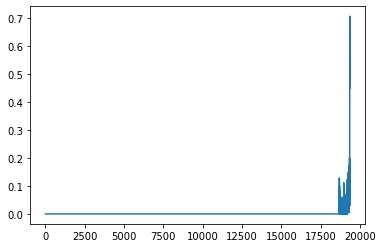

In [ ]:
### KNN
clft_knn = NearestNeighbors(n_neighbors = 10)
y_pred_knn = clft_knn.fit(Xt_scaled)
distances, indexes = clft_knn.kneighbors(Xt_scaled)
plt.plot(distances.mean(axis =1))
yt_score_knn = distances.mean(axis = 1)
yt_outlier_knn = yt_score_knn > 0.2


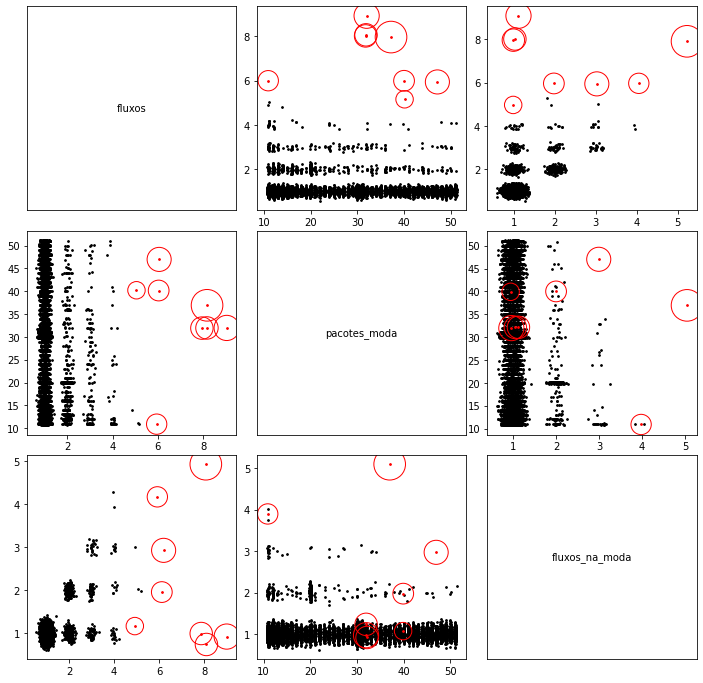

In [ ]:
pairplot_outliers(Xt, features, yt_outlier_knn, show_radius=True, y_score=yt_score_knn)

#### LOF

In [ ]:
### Local Outlier Factor
clft_lof = LocalOutlierFactor(n_neighbors=100, contamination=0.0005) # , novelty=True para usar com dados novos
#LocalOutlierFactor(n_neighbors=5, algorithm='auto',leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=0.0001) # leonardo
yt_pred_lof = clft_lof.fit_predict(Xt) # sem scaling ficou melhor
yt_outlier_lof = yt_pred_lof == -1
yt_score_lof = clft_lof.negative_outlier_factor_

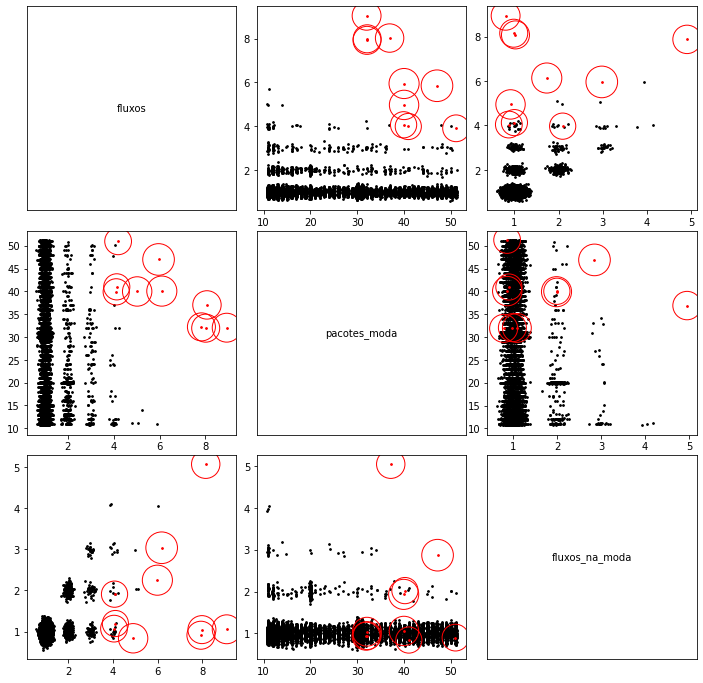

In [ ]:
pairplot_outliers (Xt, features, yt_outlier_lof, show_radius=True, y_score=-yt_score_lof)

#### One-class SVM

In [ ]:
### One Class SVM
if True:
    clft_svm = OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
    yt_pred_svm = clft_svm.fit_predict(Xt_scaled)
    yt_outlier_svm = yt_pred_svm == -1

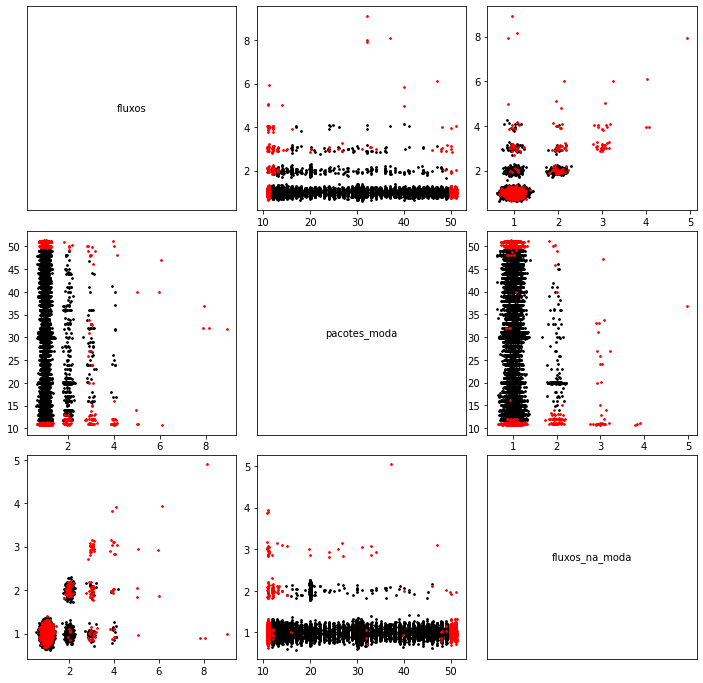

In [ ]:
pairplot_outliers (Xt, features, yt_outlier_svm, show_radius=False)

#### Isolation forest

In [ ]:
### Isolation Forest
rng = np.random.RandomState(42)
#clft_if = IsolationForest(n_estimators=100, max_samples=len(Xt), contamination=0.0005,random_state=rng, verbose=0) # leonardo
clft_if = IsolationForest(max_samples=100, random_state=rng)
yt_pred_if = clft_if.fit_predict(Xt_scaled)
yt_outlier_if = yt_pred_if == -1

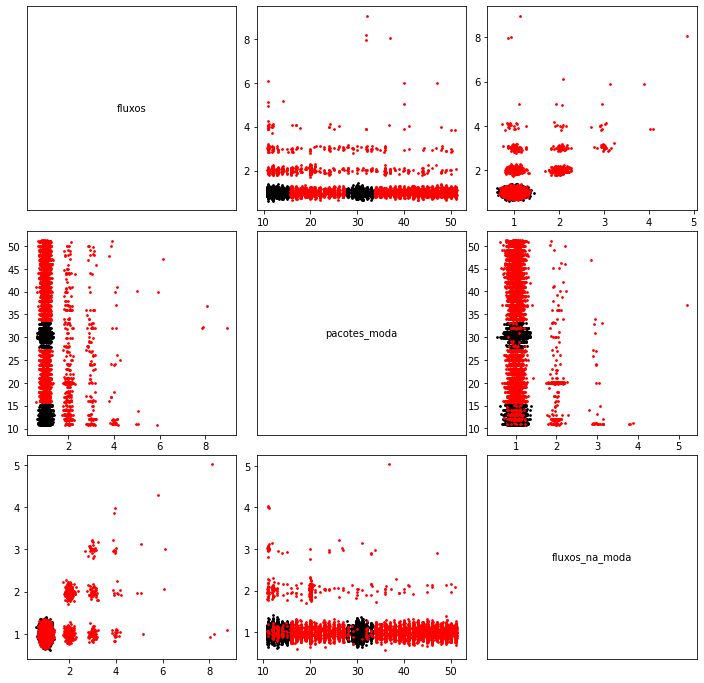

In [ ]:
pairplot_outliers (Xt, features, yt_outlier_rf, show_radius=False)